In [1]:
import sys
print(sys.version)
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

3.10.18 (main, Jun  5 2025, 08:13:51) [Clang 14.0.6 ]


In [2]:
import torch
import torchvision
import os
from os.path import join as j_
from PIL import Image
import pandas as pd
import numpy as np

# loading all packages here to start
from uni import get_encoder
from uni.downstream.extract_patch_features import extract_patch_features_from_dataloader
from uni.downstream.eval_patch_features.linear_probe import eval_linear_probe
from uni.downstream.eval_patch_features.fewshot import eval_knn, eval_fewshot
from uni.downstream.eval_patch_features.protonet import ProtoNet, prototype_topk_vote
from uni.downstream.eval_patch_features.metrics import get_eval_metrics, print_metrics
from uni.downstream.utils import concat_images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from uni import get_encoder
model, transform = get_encoder(enc_name='uni2-h', device=device)

In [4]:
from uni.downstream.extract_patch_features import extract_patch_features_from_dataloader

# get path to example data
dataroot = '../assets/data/tcga_luadlusc'

# create some image folder datasets for train/test and their data laoders
train_dataset = torchvision.datasets.ImageFolder(j_(dataroot, 'train'), transform=transform)
test_dataset = torchvision.datasets.ImageFolder(j_(dataroot, 'test'), transform=transform)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=False)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

# extract patch features from the train and test datasets (returns dictionary of embeddings and labels)
# train_features = extract_patch_features_from_dataloader(model, train_dataloader)
train_features = torch.load(f"{dataroot}/train_features.pt", map_location=torch.device('cpu'))
# train_features = torch.load(f"{dataroot}/train_features.pt")
# test_features = extract_patch_features_from_dataloader(model, test_dataloader)
test_features = torch.load(f"{dataroot}/test_features.pt", map_location=torch.device('cpu'))

# convert these to torch
train_feats = torch.Tensor(train_features['embeddings'])
train_labels = torch.Tensor(train_features['labels']).type(torch.long)
test_feats = torch.Tensor(test_features['embeddings'])
test_labels = torch.Tensor(test_features['labels']).type(torch.long)

In [5]:
from uni.downstream.eval_patch_features.linear_probe import eval_linear_probe

linprobe_eval_metrics, linprobe_dump = eval_linear_probe(
    train_feats = train_feats,
    train_labels = train_labels,
    valid_feats = None ,
    valid_labels = None,
    test_feats = test_feats,
    test_labels = test_labels,
    max_iter = 1000,
    verbose= True,
)

print_metrics(linprobe_eval_metrics)

Linear Probe Evaluation: Train shape torch.Size([130, 1536])
Linear Probe Evaluation: Test shape torch.Size([60, 1536])
Linear Probe Evaluation (Train Time): Best cost = 30.720
Linear Probe Evaluation (Train Time): Using only train set for evaluation. Train Shape:  torch.Size([130, 1536])
(Before Training) Loss: 0.693
(After Training) Loss: 0.016
Linear Probe Evaluation (Test Time): Test Shape torch.Size([60, 1536])
Linear Probe Evaluation: Time taken 0.18
Test lin_acc: 1.000
Test lin_bacc: 1.000
Test lin_kappa: 1.000
Test lin_weighted_f1: 1.000
Test lin_auroc: 1.000


In [7]:
from uni.downstream.eval_patch_features.fewshot import eval_knn

knn_eval_metrics, knn_dump, proto_eval_metrics, proto_dump = eval_knn(
    train_feats = train_feats,
    train_labels = train_labels,
    test_feats = test_feats,
    test_labels = test_labels,
    center_feats = True,
    normalize_feats = True,
    n_neighbors = 20
)

print_metrics(knn_eval_metrics)
print_metrics(proto_eval_metrics)

Test knn20_acc: 1.000
Test knn20_bacc: 1.000
Test knn20_kappa: 1.000
Test knn20_weighted_f1: 1.000
Test proto_acc: 1.000
Test proto_bacc: 1.000
Test proto_kappa: 1.000
Test proto_weighted_f1: 1.000


In [8]:
from uni.downstream.eval_patch_features.protonet import ProtoNet

# fitting the model
proto_clf = ProtoNet(metric='L2', center_feats=True, normalize_feats=True)
proto_clf.fit(train_feats, train_labels)
print('What our prototypes look like', proto_clf.prototype_embeddings.shape)

# evaluating the model
test_pred = proto_clf.predict(test_feats)
get_eval_metrics(test_labels, test_pred, get_report=False)

Num features averaged per class prototype:
	Class 0: 70
	Class 1: 60
Applying centering...
Applying normalization...
What our prototypes look like torch.Size([2, 1536])


{'acc': 1.0, 'bacc': 1.0, 'kappa': 1.0, 'weighted_f1': 1.0}

label2idx correspondenes {'LUAD': 0, 'LUSC': 1}
Top-k LUAD-like test samples to LUAD prototype


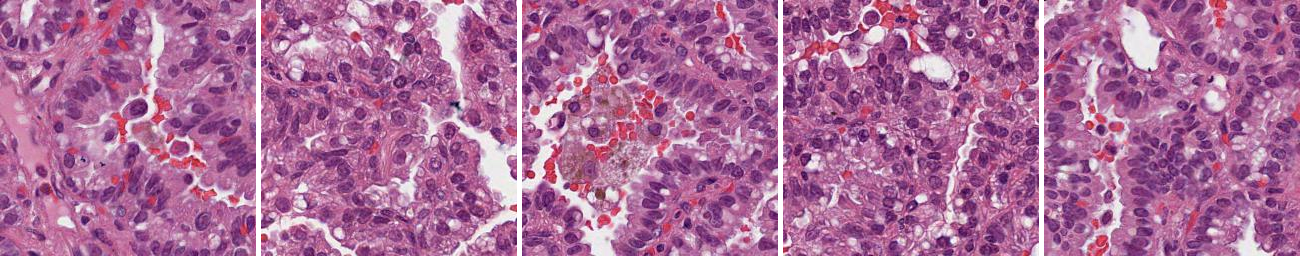

Top-k LUSC-like test samples to LUSC prototype


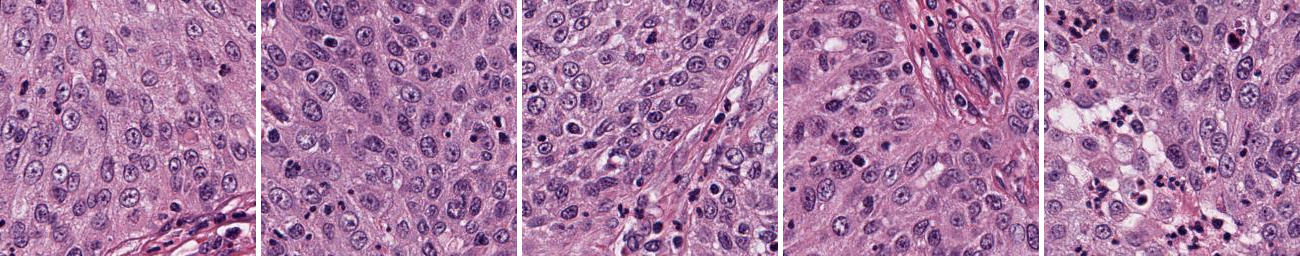

In [9]:
dist, topk_inds = proto_clf._get_topk_queries_inds(test_feats, topk=5)
train_dataset = torchvision.datasets.ImageFolder(j_(dataroot, 'train'), transform=transform)
print('label2idx correspondenes', train_dataset.class_to_idx)
test_imgs_df = pd.DataFrame(test_dataset.imgs, columns=['path', 'label'])

print('Top-k LUAD-like test samples to LUAD prototype')
luad_topk_inds = topk_inds[0]
luad_topk_imgs = concat_images([Image.open(img_fpath) for img_fpath in test_imgs_df['path'][luad_topk_inds]], scale=1, gap=5)
display(luad_topk_imgs)

print('Top-k LUSC-like test samples to LUSC prototype')
lusc_topk_inds = topk_inds[1]
lusc_topk_imgs = concat_images([Image.open(img_fpath) for img_fpath in test_imgs_df['path'][lusc_topk_inds]], scale=1, gap=5)
display(lusc_topk_imgs)